In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd "/content/drive/MyDrive"

Mounted at /content/drive
/content/drive/MyDrive


In [2]:
import datetime
import pandas as pd
import math
import tensorflow as tf
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
import os

from tensorflow.python.client import device_lib
from torch.utils.data import DataLoader, Dataset, Subset, ConcatDataset

In [3]:
print(device_lib.list_local_devices())
print("===============")
print(torch.__version__)
print("===============")
print(torch.version.cuda)
print("===============")
print(torch.backends.cudnn.version())
print("===============")
print(tf.__version__)
print("===============")
print(tf.config.list_physical_devices('GPU'))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7318191107648688711
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14626652160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14368150184741890512
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]
2.1.0+cu121
12.1
8902
2.15.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
# Fix the seed for reproducibility
seed = 999
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True

# data preprocess

In [5]:
df  = pd.read_csv("./Data_Science_for_Digital_Health/final_result.csv")
print(df.head(5))

   Unnamed: 0  index   stay_id   hadm_id  subject_id  label  \
0           0      0  30039798  27880403    18499026      0   
1           1      0  30039798  27880403    18499026      0   
2           2      0  30039798  27880403    18499026      0   
3           3      0  30039798  27880403    18499026      0   
4           4      0  30039798  27880403    18499026      0   

            icu_intime  charttime  urineoutput          icu_outtime  \
0  2137-09-15 08:36:00          0          0.0  2137-09-16 17:28:21   
1  2137-09-15 08:36:00          1        185.0  2137-09-16 17:28:21   
2  2137-09-15 08:36:00          2         82.0  2137-09-16 17:28:21   
3  2137-09-15 08:36:00          3        220.0  2137-09-16 17:28:21   
4  2137-09-15 08:36:00          4        140.0  2137-09-16 17:28:21   

   aki_stage  aki_charttime  rank  
0        0.0              0     1  
1        0.0              1     1  
2        0.0              2     1  
3        0.0              3     1  
4        0.0  

### padding data of each patient into the same length

In [6]:
stay_id_list = df["stay_id"].unique()
print("there are totally {} patients".format(len(stay_id_list)))

there are totally 49669 patients


In [7]:
longest_sequence = 0
for stay_id in stay_id_list:
    now_process = df.loc[df['stay_id'] == stay_id]
    tmp_len = len(now_process)
    if tmp_len > longest_sequence:
        longest_sequence = tmp_len
print("the longest sequence is {}".format(longest_sequence))

the longest sequence is 2438


In [8]:
## find the mean of all urine output
## use it for padding later
all_uo = np.array(df["urineoutput"].tolist())
uo_mean = np.mean(all_uo)
print("the mean urine output of all patients is: ", uo_mean)

the mean urine output of all patients is:  88.23233722797809


In [9]:
padding_hr = 24          # the first `padding_hr` nodes have no output
predict_after_hr = 6    # for each node, input the nth Hour urineOutput, output the (n + predict_after_hr)th Hour AKI_stage

X_per_patient = [] # urine output from 0H ~ (N - predict_after_hr)H
Y_per_patient = [] # AKI stage from (padding_hr + predict_after_hr)H ~ (N)H
for stay_id in stay_id_list:
    now_process = df.loc[df['stay_id'] == stay_id].reset_index()

    uo = now_process["urineoutput"].tolist()
    aki_stage = now_process["aki_stage"].tolist()

    if len(aki_stage) <=  padding_hr + predict_after_hr: # there is no enough data for predict
        continue

    # padding all patients' data to the same length with [-1]
    uo += [uo_mean] * (longest_sequence - len(uo))
    aki_stage += [4] * (longest_sequence - len(aki_stage))

    # apply padding_hr and predict_after_hr
    uo = uo[: len(uo) - predict_after_hr]
    aki_stage = aki_stage[padding_hr + predict_after_hr :]

    if len(uo) - len(aki_stage) != padding_hr:
        print("err")

    X_per_patient.append(uo)
    Y_per_patient.append(aki_stage)

print("after process, there are {} patients' data".format(len(X_per_patient)))


X_per_patient = np.array(X_per_patient)
Y_per_patient = np.array(Y_per_patient)

# the (dim of X) should be the (dim of Y) - padding_hr
print(X_per_patient.shape)
print(Y_per_patient.shape)




after process, there are 30001 patients' data
(30001, 2432)
(30001, 2408)


In [10]:
AKI_patient = 0
noAKI_patient = 0
for AKI_stages in Y_per_patient:
    if 1 in AKI_stages or 2 in AKI_stages or 3 in AKI_stages:
        AKI_patient += 1
    else:
        noAKI_patient += 1

print("therea are {} patients with AKI".format(AKI_patient))
print("therea are {} patients without AKI".format(noAKI_patient))

therea are 18553 patients with AKI
therea are 11448 patients without AKI


### Split Data

In [11]:
X_per_patient = X_per_patient[:, :, np.newaxis]
Y_per_patient = Y_per_patient[:, :, np.newaxis]

In [12]:
def shuffle(X,Y):
    randomList = np.arange(X.shape[0])
    np.random.shuffle(randomList)
    return X[randomList], Y[randomList]

X_per_patient, Y_per_patient = shuffle(X_per_patient, Y_per_patient)

In [13]:
def splitData(X, Y, val_rate, test_rate):
    X_val = X[ : int(X.shape[0]*val_rate)]
    Y_val = Y[ : int(Y.shape[0]*val_rate)]

    X_test = X[int(X.shape[0]*val_rate) : int(X.shape[0]*val_rate)+int(X.shape[0]*test_rate)]
    Y_test = Y[int(Y.shape[0]*val_rate) : int(Y.shape[0]*val_rate)+int(Y.shape[0]*test_rate)]

    X_train = X[int(X.shape[0]*val_rate)+int(X.shape[0]*test_rate) : ]
    Y_train = Y[int(Y.shape[0]*val_rate)+int(Y.shape[0]*test_rate) : ]
    return X_train, Y_train, X_val, Y_val, X_test, Y_test

In [14]:
X_train, Y_train, X_val, Y_val, X_test, Y_test = splitData(X_per_patient, Y_per_patient, val_rate=0.2, test_rate=0.1)
print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)
print(X_test.shape)
print(Y_test.shape)

(21001, 2432, 1)
(21001, 2408, 1)
(6000, 2432, 1)
(6000, 2408, 1)
(3000, 2432, 1)
(3000, 2408, 1)


# build LSTM model

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Lambda
from tensorflow.keras.optimizers import Adam
from torch import nn
from torch.nn import functional as F
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend


In [28]:
def LSTMmodel():
    model = Sequential()
    model.add(LSTM(units=50, return_sequences = True, input_shape=((longest_sequence - predict_after_hr), 1)))
    model.add(Lambda(lambda x: x[:, -(longest_sequence-predict_after_hr-padding_hr):, :])) # use Lambda() to  remove output of the first `padding_hr` nodes
    model.add(TimeDistributed((Dense(5, activation='softmax'))))

    opt = Adam(learning_rate=1e-4, clipvalue=1.0)
    model.compile(optimizer=opt,\
                  loss='sparse_categorical_crossentropy',\
                  metrics=['accuracy'])
    return model

In [29]:
LSTMmodel = LSTMmodel()
LSTMmodel.summary()
LSTMmodel.save_weights("./Data_Science_for_Digital_Health/ckpt/checkpoint.weights.0.h5")

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 2432, 50)          10400     
                                                                 
 lambda_3 (Lambda)           (None, 2408, 50)          0         
                                                                 
 time_distributed_3 (TimeDi  (None, 2408, 5)           255       
 stributed)                                                      
                                                                 
Total params: 10655 (41.62 KB)
Trainable params: 10655 (41.62 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [30]:
EScallback = EarlyStopping(monitor="val_loss", patience=10, verbose=1, mode="auto")
CKPTcallback = ModelCheckpoint(filepath="./Data_Science_for_Digital_Health/ckpt/checkpoint.weights.{epoch}.h5", monitor='val_loss',\
                               verbose=1, save_best_only=True, save_weights_only=True, mode="auto")


def scheduler(epoch, lr):
    if epoch < 20:
        return lr
    elif lr > 5e-6:
      return lr * tf.math.exp(-0.1)
    else:
        return lr
LRcallback = LearningRateScheduler(scheduler)

LSTMmodel.load_weights("./Data_Science_for_Digital_Health/ckpt/checkpoint.weights.0.h5")

history_callback = LSTMmodel.fit(X_train, Y_train, epochs=200, batch_size=128, validation_data=(X_val, Y_val), callbacks=[EScallback, CKPTcallback, LRcallback])

Epoch 1/200
165/165 [==============================] - ETA: 0s - loss: 1.4435 - accuracy: 0.2493
Epoch 1: val_loss improved from inf to 0.91814, saving model to ./Data_Science_for_Digital_Health/ckpt/checkpoint.weights.1.h5
165/165 [==============================] - 18s 97ms/step - loss: 1.4435 - accuracy: 0.2493 - val_loss: 0.9181 - val_accuracy: 0.9540 - lr: 1.0000e-04
Epoch 2/200
165/165 [==============================] - ETA: 0s - loss: 0.6322 - accuracy: 0.9657
Epoch 2: val_loss improved from 0.91814 to 0.40799, saving model to ./Data_Science_for_Digital_Health/ckpt/checkpoint.weights.2.h5
165/165 [==============================] - 16s 98ms/step - loss: 0.6322 - accuracy: 0.9657 - val_loss: 0.4080 - val_accuracy: 0.9670 - lr: 1.0000e-04
Epoch 3/200
165/165 [==============================] - ETA: 0s - loss: 0.2805 - accuracy: 0.9674
Epoch 3: val_loss improved from 0.40799 to 0.21156, saving model to ./Data_Science_for_Digital_Health/ckpt/checkpoint.weights.3.h5
165/165 [===========

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


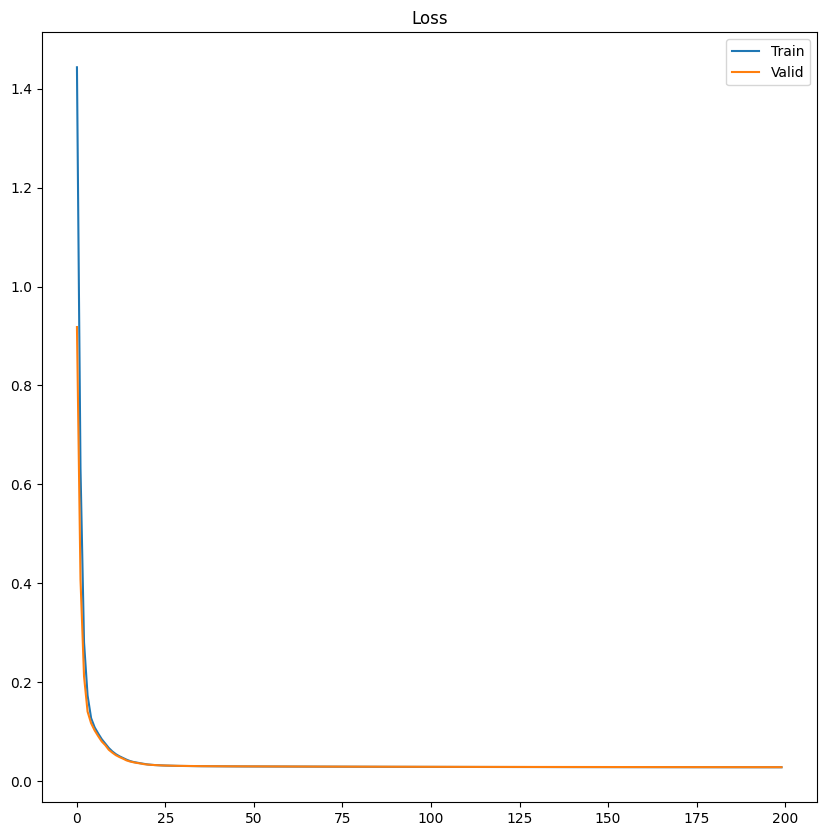

In [31]:
print(history_callback.history.keys())
total_epochs = len(history_callback.history["loss"])


fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=100)
ax.set_title('Loss')
ax.plot(range(total_epochs), history_callback.history["loss"], label='Train')
ax.plot(range(total_epochs), history_callback.history["val_loss"], label='Valid')
ax.legend()
plt.show()
fig.savefig('metrics.jpg')
plt.close()

# try to evaluate by test set

In [32]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")


In [33]:
# LSTMmodel.load_weights("ckpt/checkpoint.{}.weights.h5".format(121))
LSTMmodel.load_weights("./Data_Science_for_Digital_Health/ckpt/checkpoint.weights.200.h5")
y_pred = LSTMmodel.predict(X_test)

y_pred_oneClass = np.argmax(y_pred, axis=2)
Y_test_2D = Y_test.reshape((Y_test.shape[0], Y_test.shape[1]))

94/94 [==============================] - 3s 27ms/step


### all time accuracy (with -1 padding)

In [34]:
### 5 classes
y_pred_flatten = y_pred_oneClass.reshape((-1))
y_test_flatten = Y_test_2D.reshape((-1))

print(classification_report(y_test_flatten, y_pred_flatten))
print(accuracy_score(y_test_flatten, y_pred_flatten))
print(confusion_matrix(y_test_flatten, y_pred_flatten))

print("=================")

### 3 classes
y_pred_flatten_3 = np.array(y_pred_flatten)
y_test_flatten_3 = np.array(y_test_flatten)

y_pred_flatten_3[y_pred_flatten_3 == 2] = 1
y_pred_flatten_3[y_pred_flatten_3 == 3] = 1
y_test_flatten_3[y_test_flatten_3 == 2] = 1
y_test_flatten_3[y_test_flatten_3 == 3] = 1

print(classification_report(y_test_flatten_3, y_pred_flatten_3))
print(accuracy_score(y_test_flatten_3, y_pred_flatten_3))
print(confusion_matrix(y_test_flatten_3, y_pred_flatten_3))


              precision    recall  f1-score   support

         0.0       0.80      0.92      0.85    191224
         1.0       0.23      0.00      0.00     10211
         2.0       0.42      0.37      0.39     25351
         3.0       0.69      0.75      0.72     26341
         4.0       1.00      1.00      1.00   6970873

    accuracy                           0.99   7224000
   macro avg       0.63      0.61      0.59   7224000
weighted avg       0.99      0.99      0.99   7224000

0.9903205980066445
[[ 175274       3    7605    5758    2584]
 [   9002       3    1016      82     108]
 [  13994       2    9476    1624     255]
 [   3768       5    2780   19633     155]
 [  18100       0    1819    1264 6949690]]
              precision    recall  f1-score   support

         0.0       0.80      0.92      0.85    191224
         1.0       0.68      0.56      0.61     61903
         4.0       1.00      1.00      1.00   6970873

    accuracy                           0.99   7224000
   m

### without -1 padding

In [35]:
### 5 classes
y_pred_nopad = []
y_test_nopad = []
for yp, yt in zip(y_pred_oneClass, Y_test_2D):
    yt_tmp = np.delete(yt, np.where(yt == 4))
    yp_tmp = yp[: yt_tmp.shape[0]]

    y_test_nopad = [*y_test_nopad, *yt_tmp]
    y_pred_nopad = [*y_pred_nopad, *yp_tmp]


print(classification_report(y_test_nopad, y_pred_nopad))
print(accuracy_score(y_test_nopad, y_pred_nopad))
print(confusion_matrix(y_test_nopad, y_pred_nopad))

print("=============")
### 3 classes
y_pred_nopad_3 = np.array(y_pred_nopad)
y_test_nopad_3 = np.array(y_test_nopad)

y_pred_nopad_3[y_pred_nopad_3 == 2] = 1
y_pred_nopad_3[y_pred_nopad_3 == 3] = 1
y_test_nopad_3[y_test_nopad_3 == 2] = 1
y_test_nopad_3[y_test_nopad_3 == 3] = 1

print(classification_report(y_test_nopad_3, y_pred_nopad_3))
print(accuracy_score(y_test_nopad_3, y_pred_nopad_3))
print(confusion_matrix(y_test_nopad_3, y_pred_nopad_3))

              precision    recall  f1-score   support

         0.0       0.87      0.92      0.89    191224
         1.0       0.23      0.00      0.00     10211
         2.0       0.45      0.37      0.41     25351
         3.0       0.72      0.75      0.73     26341
         4.0       0.00      0.00      0.00         0

    accuracy                           0.81    253127
   macro avg       0.46      0.41      0.41    253127
weighted avg       0.79      0.81      0.79    253127

0.8074444843892592
[[175274      3   7605   5758   2584]
 [  9002      3   1016     82    108]
 [ 13994      2   9476   1624    255]
 [  3768      5   2780  19633    155]
 [     0      0      0      0      0]]
              precision    recall  f1-score   support

         0.0       0.87      0.92      0.89    191224
         1.0       0.72      0.56      0.63     61903
         4.0       0.00      0.00      0.00         0

    accuracy                           0.83    253127
   macro avg       0.53      

### without -1 padding, last 5 hours


In [36]:
### 5 classes
y_pred_last5 = []
y_test_last5 = []
for yp, yt in zip(y_pred_oneClass, Y_test_2D):
    yt_tmp = np.delete(yt, np.where(yt == 4))
    yp_tmp = yp[: yt_tmp.shape[0]]

    y_test_last5 = [*y_test_last5, *yt_tmp[-5:]]
    y_pred_last5 = [*y_pred_last5, *yp_tmp[-5:]]


print(classification_report(y_test_last5, y_pred_last5))
print(accuracy_score(y_test_last5, y_pred_last5))
print(confusion_matrix(y_test_last5, y_pred_last5))

print("=============")
### 3 classes
y_pred_last5_3 = np.array(y_pred_last5)
y_test_last5_3 = np.array(y_test_last5)

y_pred_last5_3[y_pred_last5_3 == 2] = 1
y_pred_last5_3[y_pred_last5_3 == 3] = 1
y_test_last5_3[y_test_last5_3 == 2] = 1
y_test_last5_3[y_test_last5_3 == 3] = 1

print(classification_report(y_test_last5_3, y_pred_last5_3))
print(accuracy_score(y_test_last5_3, y_pred_last5_3))
print(confusion_matrix(y_test_last5_3, y_pred_last5_3))

              precision    recall  f1-score   support

         0.0       0.88      0.90      0.89     11510
         1.0       0.00      0.00      0.00       653
         2.0       0.43      0.42      0.42      1473
         3.0       0.59      0.72      0.65       810
         4.0       0.00      0.00      0.00         0

    accuracy                           0.80     14446
   macro avg       0.38      0.41      0.39     14446
weighted avg       0.78      0.80      0.79     14446

0.7982832618025751
[[10336     1   641   307   225]
 [  559     0    83     3     8]
 [  732     0   614    98    29]
 [  141     0    80   582     7]
 [    0     0     0     0     0]]
              precision    recall  f1-score   support

         0.0       0.88      0.90      0.89     11510
         1.0       0.61      0.50      0.55      2936
         4.0       0.00      0.00      0.00         0

    accuracy                           0.82     14446
   macro avg       0.49      0.47      0.48     14446
